In [1128]:
import pandas as pd
import numpy as np

from statsmodels.formula.api import ols
import statsmodels.stats.diagnostic as cu
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts 
import scipy.stats
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.stattools import durbin_watson

import statsmodels.api as sm
import warnings
warnings.filterwarnings(action='ignore')




In [1129]:
real_gdp_log = pd.read_csv("preprocessed_data/real_gdp_log.csv", index_col="Year")
total_work_hours_log = pd.read_csv("preprocessed_data/total_work_hours_log.csv", index_col="Year")
capital_stock_log = pd.read_csv("preprocessed_data/capital_stock_log.csv", index_col="Year")

#employment = pd.read_csv("employment.csv", index_col="Year")


In [1130]:
def print_adfuller (x):
    #result = adfuller(x)
    result = adfuller(x, maxlag=1, autolag=None, regression='ct')   #각 데이터 모두 trend가 존재한다고 판단하여 옵션을 "ct"로 줌
    print(f'ADF Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


def print_coint (y, x, t):
    result = coint(y, x, trend=t)  
    print(f'coint T-Statistic: {result[0]:.3f}')
    print(f'p-value: {result[1]:.3f}')
    print('Critical Values:')
    for value in result[2]:
        print('\t: %.3f' % (value))

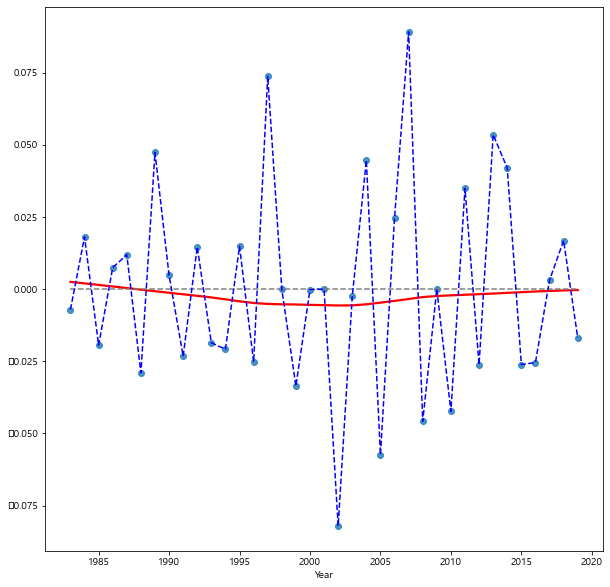

In [1131]:
residual = korea['lnY'] - Y_predict


plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


In [1132]:
korea = pd.concat([real_gdp_log['Korea'], capital_stock_log['Korea'], total_work_hours_log['Korea']], axis=1)
korea.columns = ['lnY', 'lnK', 'lnL']
korea.dropna(axis=0, inplace=True)

korea['trend'] = np.log(range(1, len(korea)+1))
korea['trend'] = korea['trend']

korea['dummy_85_to_87'] = np.zeros(len(korea))
korea.at[range(1985,1988), 'dummy_85_to_87'] =1

korea['dummy_88_to_91'] = np.zeros(len(korea))
korea.at[range(1988,1992), 'dummy_88_to_91'] =1

korea['dummy_97_to_04'] = np.zeros(len(korea))
korea.at[range(1997,2005), 'dummy_97_to_04'] =1

korea['dummy_98'] = np.zeros(len(korea))
korea.at[range(1998,1999), 'dummy_98'] =1

korea['dummy_01'] = np.zeros(len(korea))
korea.at[range(2001,2002), 'dummy_01'] =1

korea['dummy_09'] = np.zeros(len(korea))
korea.at[range(2009,2010), 'dummy_09'] =1

korea['dummy_18_to_19'] = np.zeros(len(korea))
korea.at[range(2018,2020), 'dummy_18_to_19'] =1


korea['IMF'] = np.zeros(len(korea))
korea.at[range(1997,2005), 'IMF'] =1



korea['SPM'] = np.zeros(len(korea))
korea.at[range(2008,2010), 'SPM'] =1


#korea.to_csv("한국최종데이터.csv", index=False)

ADF test (단위근, 정상성 검정)


: 한국의 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.14, 0.24, 0.45로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

모두 non-stationary하다

In [1133]:
print_adfuller(korea['lnY'])
print()
print_adfuller(korea['lnL'])
print()
print_adfuller(korea['lnK'])


ADF Statistic: -2.974
p-value: 0.140
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.683
p-value: 0.243
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205

ADF Statistic: -2.267
p-value: 0.452
Critical Values:
	1%: -4.244
	5%: -3.544
	10%: -3.205


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 한국의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.026으로 


공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.05에서 기각한다.

따라서 공적분 관계가 존재한다.

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html

In [1134]:
#coint(korea['lnY'], korea[['lnK', 'lnL']], trend='ct')
print_coint(korea['lnY'], korea[['lnK', 'lnL']], 'ct')

coint T-Statistic: -4.349
p-value: 0.026
Critical Values:
	: -5.221
	: -4.462
	: -4.093


In [1135]:
model = ols("lnY ~ lnK + lnL + trend + dummy_85_to_87 + dummy_88_to_91 + dummy_97_to_04 + dummy_98 + dummy_01 +dummy_09 + dummy_18_to_19", data = korea).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     497.7
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           4.71e-27
Time:                        20:47:07   Log-Likelihood:                 71.299
No. Observations:                  37   AIC:                            -120.6
Df Residuals:                      26   BIC:                            -102.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -8.1874      5.730     -1.429      0.165     -19.966       3.591
lnK                0.4246      0.056      7.518      0.000       0.309       0.541
lnL                1.6450      0.318      5.180      0.000       0.992       2.298
trend              0.0213      0.058      0.365      0.718      -0.099       0.141
dummy_85_to_87    -0.0702      0.041     -1.696      0.102      -0.155       0.015
dummy_88_to_91     0.0926      0.034      2.736      0.011       0.023       0.162
dummy_97_to_04    -0.2444      0.020    -12.049      0.000      -0.286      -0.203
dummy_98          -0.2443      0.050     -4.902      0.000      -0.347      -0.142
dummy_01          -0.1367      0.045     -3.008      0.006      -0.230      -0.043
dummy_09          -0.1921      0.044     -4.373      0.000      -0.282      -0.102
dummy_18_to_19     0.0721      0.035      2.088      0.047       0.001       0.143
==============================================================================
Omnibus:                        1.423   Durbin-Watson:                   2.557
Prob(Omnibus):                  0.491   Jarque-Bera (JB):                0.720
Skew:                           0.323   Prob(JB):                        0.698
Kurtosis:                       3.221   Cond. No.                     1.96e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

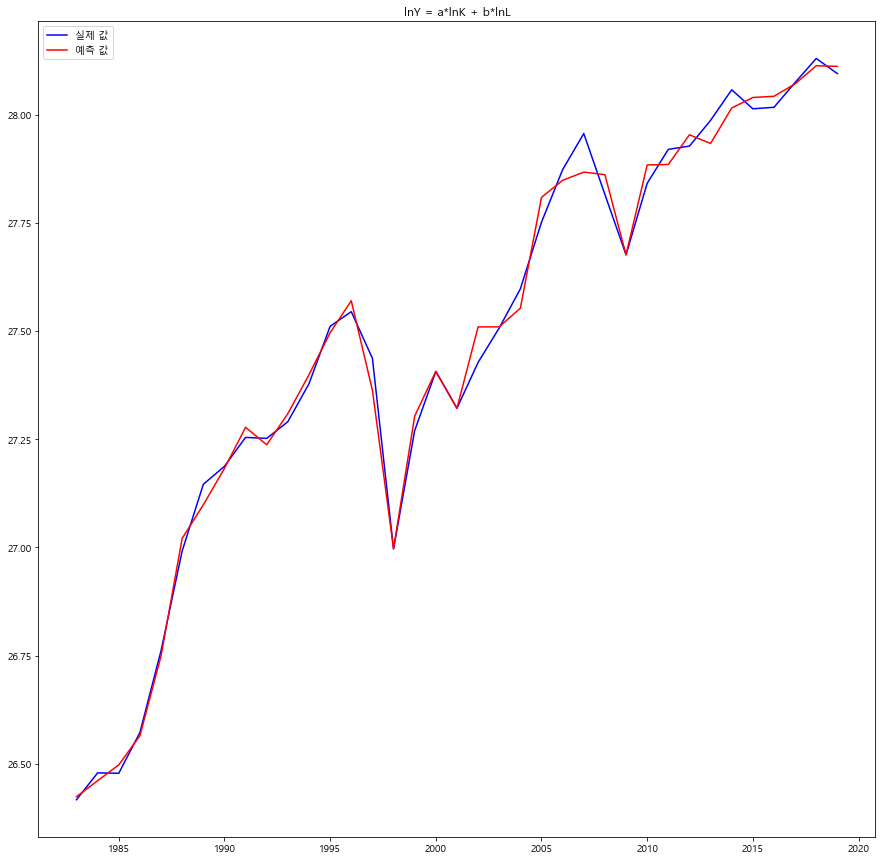

In [1136]:
#Y_predict = ols("lnY ~ lnK + lnL", data = korea).fit().predict(korea)
Y_predict = model.predict(korea)


plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(korea.index, korea['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')

plt.title("lnY = a*lnK + b*lnL")
plt.legend()

=> lnK, lnL 변수만 사용했을때, 회귀분석 적용 결과

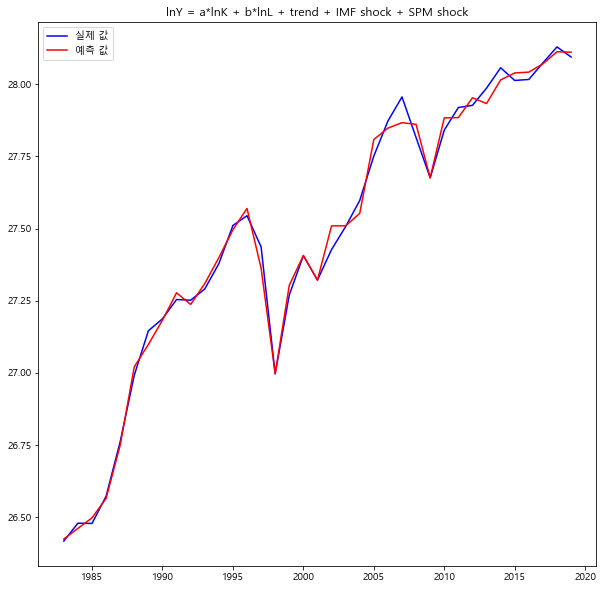

In [1137]:
Y_predict = model.predict(korea)

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(korea.index, korea['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')

plt.title("lnY = a*lnK + b*lnL + trend + IMF shock + SPM shock")
plt.legend()

=> 추세 + 더미변수 등 추가했을때, 최종 결과

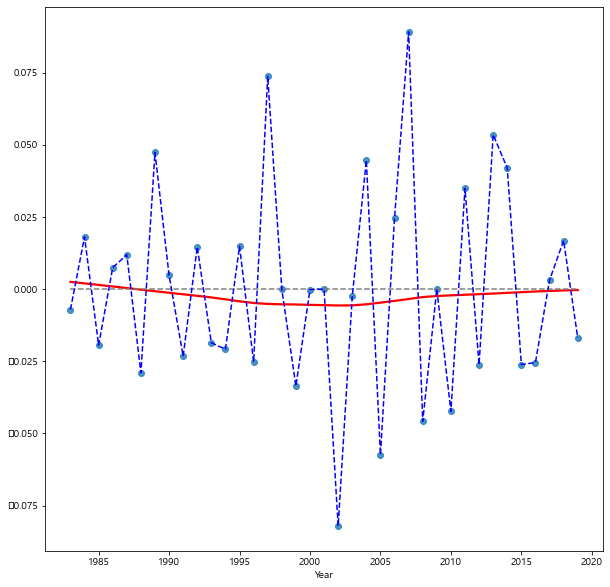

In [1138]:
residual = korea['lnY'] - Y_predict


plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


-> 잔차도를 분석해봤을 떄, 특정 패턴이 나타나지 않으므로 등분산성을 만족한다

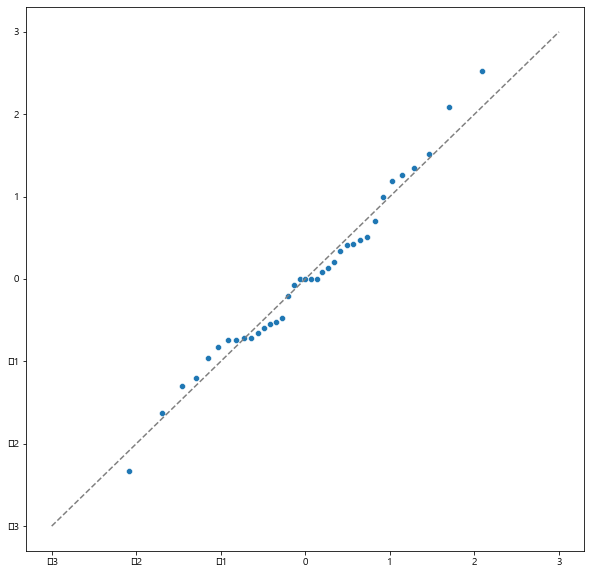

In [1139]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

-> Q-Q plot으로 잔차가 정규분포를 따르는지 확인해본 결과

선에서 벗어나지 않았으므로 정규분포를 따른다

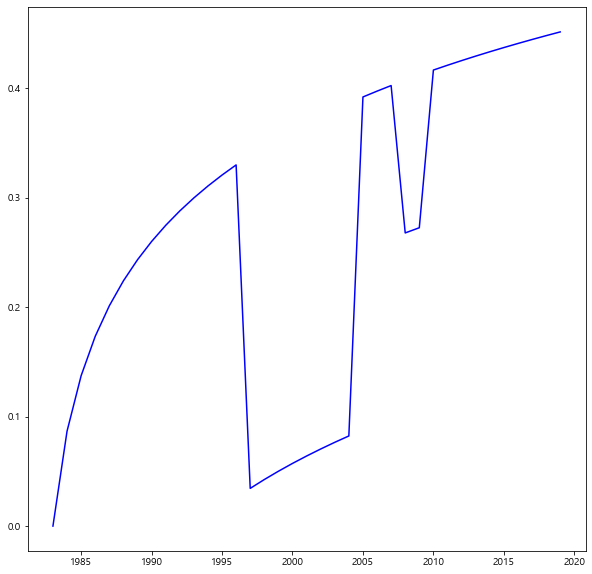

In [1140]:
lnA = korea['trend']*0.1251 + korea['IMF']*(-0.3043) + korea['SPM']*(-0.1396)

#print(lnA)
#for i in lnA.index:
#    lnA[i] = np.exp(lnA[i])

#print(lnA)
plt.plot(lnA.index, lnA, color='blue')


위 회귀분석 식에 따른 lnA (총요소생산성)

In [1141]:
Y = korea['lnY'].to_numpy()
Y_avg = np.average(Y)
feture = korea.drop('lnY', axis=1)
X = feture.to_numpy()

N = len(korea)
K = len(feture.columns)
print(K)

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)
for i, b in enumerate(beta):
    print(feture.columns[i], "의 계수 값 : ", np.around(b,4))



12


LinAlgError: Singular matrix

In [ ]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

print("Durbin Watson : ", durbin_watson(resid))


SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()

print("R-sauare : ", R_square)
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )
print("adj R-sauare : ", adj_R_square)

beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta
for i, b in enumerate(beta):
    print(feture.columns[i], '의T 통계량 : ', np.around(t_value[i],4))

Durbin Watson :  1.9516396200930464
R-sauare :  0.966877791102477
adj R-sauare :  0.9752840007477663
lnK 의T 통계량 :  5.2504
lnL 의T 통계량 :  23.0326
trend 의T 통계량 :  2.3302
IMF 의T 통계량 :  -9.6938
SPM 의T 통계량 :  -2.4243


In [ ]:
R = np.array([[1, 1, 0, 0, 0]])
r = np.array([1])

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

print("[KOREA] Wald Test 카이제곱통계량 : ", chai_sq)

[KOREA] Wald Test 카이제곱통계량 :  1128.3940639714863


In [ ]:
usa = pd.concat([real_gdp_log['USA'], capital_stock_log['USA'], total_work_hours_log['USA']], axis=1).dropna()
usa.columns = ['lnY', 'lnK', 'lnL']
usa['trend'] = (range(1, len(usa)+1))
usa['trend'] = usa['trend']

usa['dummy_60_to_61'] = np.zeros(len(usa))
usa.at[range(1960,1962), 'dummy_60_to_61'] =1

usa['dummy_65'] = np.zeros(len(usa))
usa.at[range(1965,1966), 'dummy_65'] =1

usa['dummy_66_to_69'] = np.zeros(len(usa))
usa.at[range(1966,1970), 'dummy_66_to_69'] =1

usa['dummy_71_to_73'] = np.zeros(len(usa))
usa.at[range(1971,1974), 'dummy_71_to_73'] =1

usa['dummy_80_to_96'] = np.zeros(len(usa))
usa.at[range(1980,1997), 'dummy_80_to_96'] =1

usa['dummy_82_to_83'] = np.zeros(len(usa))
usa.at[range(1982,1984), 'dummy_82_to_83'] =1

usa['dummy_91'] = np.zeros(len(usa))
usa.at[range(1991,1992), 'dummy_91'] =1

usa['dummy_97_to_98'] = np.zeros(len(usa))
usa.at[range(1997,1999), 'dummy_97_to_98'] =1

usa['dummy_04_to_06'] = np.zeros(len(usa))
usa.at[range(2004,2007), 'dummy_04_to_06'] =1

usa['dummy_08_to_09'] = np.zeros(len(usa))
usa.at[range(2008,2010), 'dummy_08_to_09'] =1




#usa.to_csv("미국최종데이터.csv", index=False)
usa

,lnY,lnK,lnL,trend,dummy_60_to_61,dummy_65,dummy_66_to_69,dummy_71_to_73,dummy_80_to_96,dummy_82_to_83,dummy_91,dummy_97_to_98,dummy_04_to_06,dummy_08_to_09,intercept
Year,,,,,,,,,,,,,,,
1960,28.871477,16.504169,18.670620,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1961,28.894216,16.537153,18.664504,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1962,28.953428,16.572959,18.688697,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1963,28.996488,16.610436,18.710573,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1964,29.052868,16.650116,18.734587,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1965,29.114903,16.692038,18.764545,6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1966,29.177878,16.734955,18.784636,7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1967,29.202571,16.773725,18.792927,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1968,29.249454,16.812002,18.807879,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ADF test (단위근, 정상성 검정)


: 미국 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.36, 0.88, 0.66으로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

따라서 non-stationary하다

In [ ]:
print_adfuller(usa['lnY'])
print()
print_adfuller(usa['lnK'])
print()
print_adfuller(usa['lnL'])


ADF Statistic: -2.429
p-value: 0.364
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.319
p-value: 0.883
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173

ADF Statistic: -1.872
p-value: 0.669
Critical Values:
	1%: -4.124
	5%: -3.489
	10%: -3.173


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 미국의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.097로 

공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.1에서 기각할 수 있으며

공적분 관계가 존재한다.

In [ ]:
#coint(usa['lnY'], usa[['lnK', 'lnL']], trend='ctt')
print_coint(usa['lnY'], usa[['lnK', 'lnL']], 'ctt')

coint T-Statistic: -4.188
p-value: 0.097
Critical Values:
	: -5.412
	: -4.729
	: -4.389


In [ ]:
model = ols("lnY ~ lnK + lnL + trend + dummy_60_to_61 + dummy_65 + dummy_66_to_69 + dummy_71_to_73 + dummy_80_to_96 + dummy_82_to_83 + dummy_91 + dummy_97_to_98 + dummy_04_to_06 + dummy_08_to_09"
            , data = usa).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.570e+04
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           6.43e-92
Time:                        20:29:00   Log-Likelihood:                 244.89
No. Observations:                  60   AIC:                            -461.8
Df Residuals:                      46   BIC:                            -432.5
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.6065      0.328     23.175      0.000       6.946       8.267
lnK                0.5833      0.026     22.857      0.000       0.532       0.635
lnL                0.6243      0.027     23.183      0.000       0.570       0.679
trend              0.0057      0.000     12.722      0.000       0.005       0.007
dummy_60_to_61    -0.0232      0.004     -5.429      0.000      -0.032      -0.015
dummy_65           0.0225      0.005      4.430      0.000       0.012       0.033
dummy_66_to_69     0.0373      0.003     13.156      0.000       0.032       0.043
dummy_71_to_73     0.0216      0.003      6.988      0.000       0.015       0.028
dummy_80_to_96    -0.0352      0.002    -17.676      0.000      -0.039      -0.031
dummy_82_to_83    -0.0190      0.004     -5.006      0.000      -0.027      -0.011
dummy_91          -0.0146      0.005     -3.028      0.004      -0.024      -0.005
dummy_97_to_98    -0.0207      0.004     -5.391      0.000      -0.028      -0.013
dummy_04_to_06     0.0145      0.003      4.692      0.000       0.008       0.021
dummy_08_to_09    -0.0086      0.004     -2.328      0.024      -0.016      -0.001
==============================================================================
Omnibus:                        0.829   Durbin-Watson:                   2.697
Prob(Omnibus):                  0.661   Jarque-Bera (JB):                0.811
Skew:                          -0.003   Prob(JB):                        0.667
Kurtosis:                       2.430   Cond. No.                     2.31e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Durbin Watson :  2.696733364697933


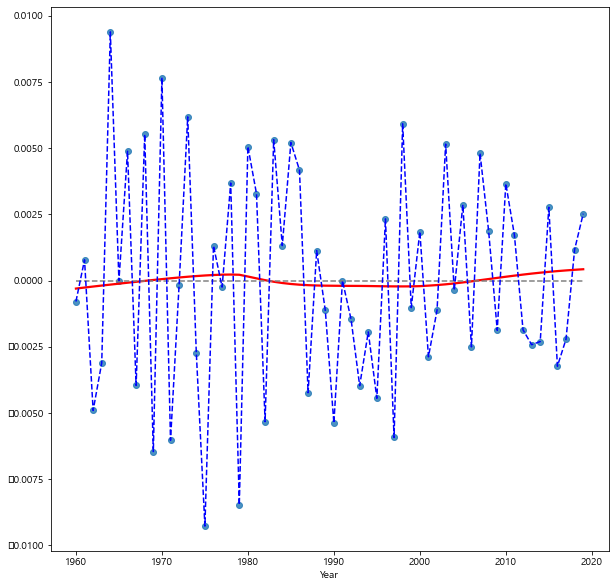

In [ ]:
Y_predict = model.predict(usa)
residual = usa['lnY'] - Y_predict

print("Durbin Watson : ", durbin_watson(residual))

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
#sns.regplot(usa['lnY'], residual, lowess=True, line_kws={'color': 'red'})

plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
#plt.plot([usa['lnY'].min(), usa['lnY'].max()], [0, 0], '--', color='grey')

plt.plot(residual.index, residual, '--', color='blue')


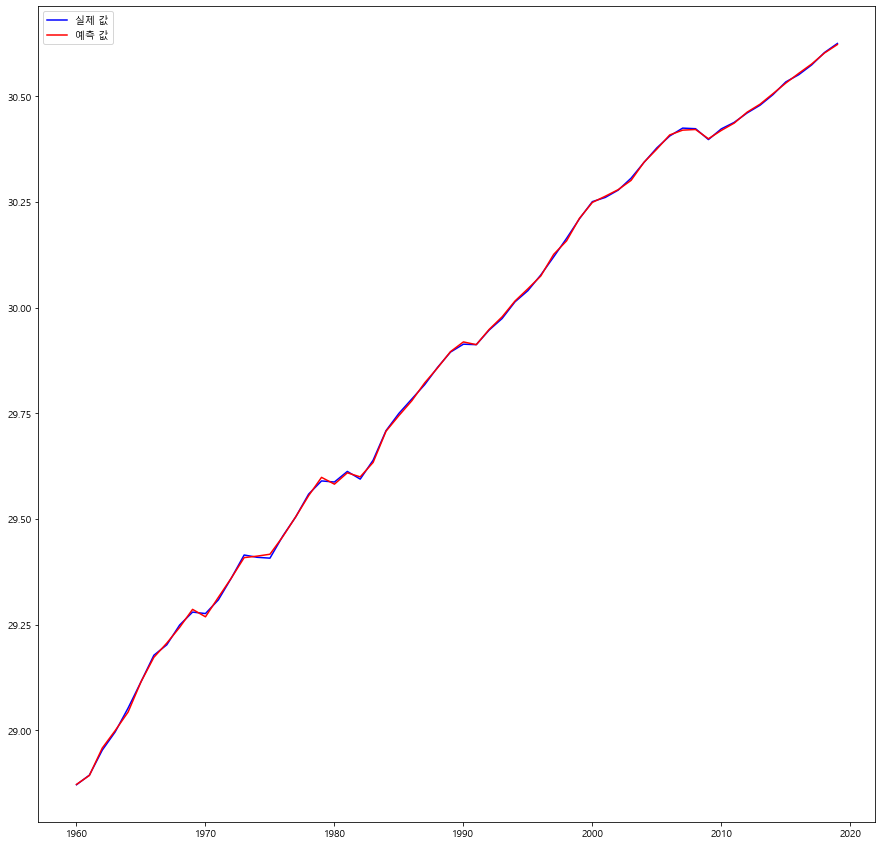

In [ ]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(usa.index, usa['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


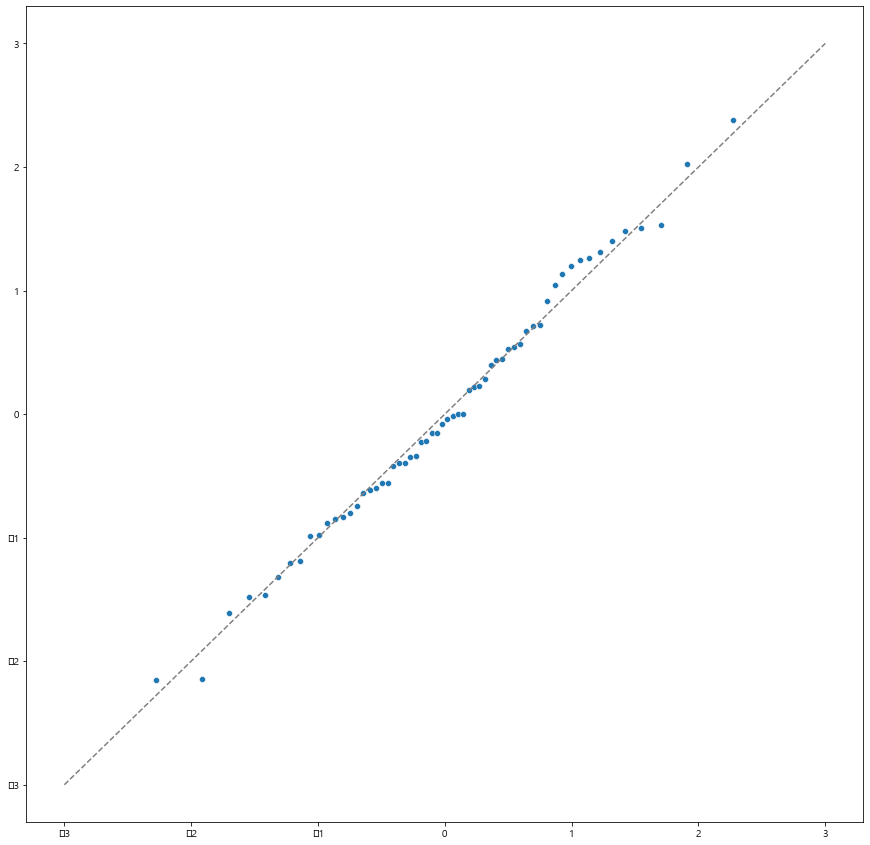

In [ ]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

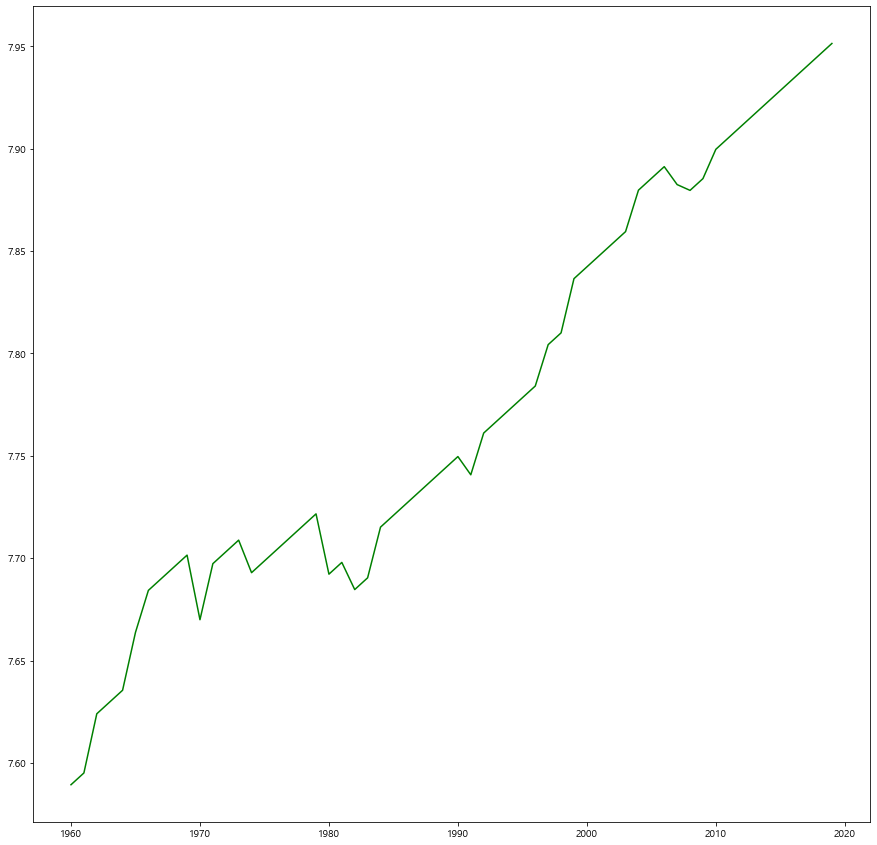

In [ ]:
lnA = Y_predict - usa['lnK'] *0.5833 - usa['lnL'] * 0.6243

plt.plot(lnA.index, lnA, color='green')


In [ ]:
Y = usa['lnY'].to_numpy()
Y_avg = np.average(Y)
feture = usa.drop('lnY', axis=1)
X = feture.to_numpy()

N = len(usa)
K = len(feture.columns)

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)
for i, b in enumerate(beta):
    print(feture.columns[i], "의 계수 값 : ", np.around(b,4))



lnK 의 계수 값 :  0.5833
lnL 의 계수 값 :  0.6243
trend 의 계수 값 :  0.0057
dummy_60_to_61 의 계수 값 :  -0.0232
dummy_65 의 계수 값 :  0.0225
dummy_66_to_69 의 계수 값 :  0.0373
dummy_71_to_73 의 계수 값 :  0.0216
dummy_80_to_96 의 계수 값 :  -0.0352
dummy_82_to_83 의 계수 값 :  -0.019
dummy_91 의 계수 값 :  -0.0146
dummy_97_to_98 의 계수 값 :  -0.0207
dummy_04_to_06 의 계수 값 :  0.0145
dummy_08_to_09 의 계수 값 :  -0.0086
intercept 의 계수 값 :  7.6065


In [ ]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

print("Durbin Watson : ", durbin_watson(resid))


SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()

print("R-sauare : ", R_square)
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )
print("adj R-sauare : ", adj_R_square)

beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta
for i, b in enumerate(beta):
    print(feture.columns[i], '의T 통계량 : ', np.around(t_value[i],4))

Durbin Watson :  2.6967333654380696
R-sauare :  0.9999364805917923
adj R-sauare :  0.9999171488055971
lnK 의T 통계량 :  22.8567
lnL 의T 통계량 :  23.1828
trend 의T 통계량 :  12.7215
dummy_60_to_61 의T 통계량 :  -5.4288
dummy_65 의T 통계량 :  4.4302
dummy_66_to_69 의T 통계량 :  13.1558
dummy_71_to_73 의T 통계량 :  6.9883
dummy_80_to_96 의T 통계량 :  -17.6761
dummy_82_to_83 의T 통계량 :  -5.0057
dummy_91 의T 통계량 :  -3.0284
dummy_97_to_98 의T 통계량 :  -5.3909
dummy_04_to_06 의T 통계량 :  4.6916
dummy_08_to_09 의T 통계량 :  -2.3281
intercept 의T 통계량 :  23.1745


In [ ]:
R = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
r = np.array([1])

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

print("[USA] Wald Test 카이제곱통계량 : ", chai_sq)

[USA] Wald Test 카이제곱통계량 :  131.2248672526746


In [1143]:
japan = pd.concat([real_gdp_log['Japan'], capital_stock_log['Japan'], total_work_hours_log['Japan']], axis=1).dropna()
japan.columns = ['lnY', 'lnK', 'lnL']
japan['trend'] = np.sqrt(range(1, len(japan)+1))
japan['trend'] = japan['trend']

japan['dummy_70_to_73'] = np.zeros(len(japan))
japan.at[range(1970,1974), 'dummy_70_to_73'] =1

japan['dummy_76_to_77'] = np.zeros(len(japan))
japan.at[range(1976,1978), 'dummy_76_to_77'] =1

japan['dummy_80_to_81'] = np.zeros(len(japan))
japan.at[range(1980,1982), 'dummy_80_to_81'] =1

japan['dummy_82_to_85'] = np.zeros(len(japan))
japan.at[range(1982,1986), 'dummy_82_to_85'] =1

japan['dummy_88'] = np.zeros(len(japan))
japan.at[range(1988,1989), 'dummy_88'] =1

japan['dummy_93_to_95'] = np.zeros(len(japan))
japan.at[range(1993,1996), 'dummy_93_to_95'] =1

japan['dummy_98'] = np.zeros(len(japan))
japan.at[range(1998,1999), 'dummy_98'] =1

japan['dummy_01_to_02'] = np.zeros(len(japan))
japan.at[range(2001,2003), 'dummy_01_to_02'] =1

japan['dummy_09_to_10'] = np.zeros(len(japan))
japan.at[range(2009,2011), 'dummy_09_to_10'] =1

japan['dummy_11_to_12'] = np.zeros(len(japan))
japan.at[range(2011,2013), 'dummy_11_to_12'] =1

japan['dummy_13'] = np.zeros(len(japan))
japan.at[range(2013,2014), 'dummy_13'] =1

japan['intercept'] = np.ones(len(japan))


japan.to_csv("일본최종데이터.csv", index=False)
japan


,lnY,lnK,lnL,trend,dummy_70_to_73,dummy_76_to_77,dummy_80_to_81,dummy_82_to_85,dummy_88,dummy_93_to_95,dummy_98,dummy_01_to_02,dummy_09_to_10,dummy_11_to_12,dummy_13,intercept
Year,,,,,,,,,,,,,,,,
1970,26.919705,15.477723,18.553957,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1971,26.991862,15.595414,18.557637,1.414214,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1972,27.218209,15.708076,18.557096,1.732051,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1973,27.405071,15.819373,18.566948,2.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1974,27.320410,15.902431,18.533216,2.236068,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1975,27.334878,15.974494,18.518739,2.449490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1976,27.374650,16.041853,18.535403,2.645751,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1977,27.516953,16.105077,18.549286,2.828427,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1978,27.812007,16.169214,18.558759,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


ADF test (단위근, 정상성 검정)


: 일본 lnY, lnL, lnK 각 데이터는 

p-value가 각각 0.78, 0.87, 0.81으로

단위근이 존재한다(정상성stationary을 만족하지 못한다)는 귀무가설을 기각하지 못한다

따라서 non-stationary하다

In [1144]:
print_adfuller(japan['lnY'])
print()
print_adfuller(japan['lnK'])
print()
print_adfuller(japan['lnL'])


ADF Statistic: -1.613
p-value: 0.787
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.350
p-value: 0.875
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183

ADF Statistic: -1.546
p-value: 0.813
Critical Values:
	1%: -4.161
	5%: -3.506
	10%: -3.183


Augmented Engle-Granger two-step Cointegration Test (공적분 검정)

: 일본의 lnY와 lnK, lnL 데이터는

검정 결과 p-value값은 0.048로 

공적분 관계가 존재하지 않는다는 귀무가설(H0)을 유의수준 0.05에서 기각할 수 있으며

공적분 관계가 존재한다.

In [1145]:
#coint(japan['lnY'], japan[['lnK', 'lnL']])
print_coint(japan['lnY'], japan[['lnK', 'lnL']], 'c')

coint T-Statistic: -3.754
p-value: 0.048
Critical Values:
	: -4.602
	: -3.920
	: -3.581


In [1146]:
model = ols("lnY ~ lnK + lnL + trend + dummy_70_to_73 + dummy_76_to_77 + dummy_80_to_81 + dummy_82_to_85 + dummy_88 + dummy_93_to_95 + dummy_98  + dummy_01_to_02 + dummy_09_to_10 + dummy_11_to_12 + dummy_13"
            , data = japan).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    lnY   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     954.6
Date:                Mon, 06 Jun 2022   Prob (F-statistic):           7.21e-41
Time:                        20:48:02   Log-Likelihood:                 91.583
No. Observations:                  50   AIC:                            -153.2
Df Residuals:                      35   BIC:                            -124.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -17.0294      4.106     -4.147      0.000     -25.365      -8.694
lnK                1.3053      0.118     11.037      0.000       1.065       1.545
lnL                1.2611      0.282      4.480      0.000       0.690       1.833
trend              0.0877      0.032      2.743      0.010       0.023       0.153
dummy_70_to_73     0.1952      0.041      4.808      0.000       0.113       0.278
dummy_76_to_77    -0.1297      0.040     -3.277      0.002      -0.210      -0.049
dummy_80_to_81    -0.1412      0.036     -3.896      0.000      -0.215      -0.068
dummy_82_to_85    -0.3411      0.027    -12.554      0.000      -0.396      -0.286
dummy_88           0.1448      0.050      2.910      0.006       0.044       0.246
dummy_93_to_95     0.1830      0.030      6.041      0.000       0.121       0.244
dummy_98          -0.1551      0.049     -3.190      0.003      -0.254      -0.056
dummy_01_to_02    -0.1057      0.037     -2.835      0.008      -0.181      -0.030
dummy_09_to_10     0.2008      0.038      5.319      0.000       0.124       0.277
dummy_11_to_12     0.3414      0.036      9.355      0.000       0.267       0.415
dummy_13           0.1493      0.049      3.060      0.004       0.050       0.248
==============================================================================
Omnibus:                        1.474   Durbin-Watson:                   2.489
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.080
Skew:                           0.031   Prob(JB):                        0.583
Kurtosis:                       2.283   Cond. No.                     1.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

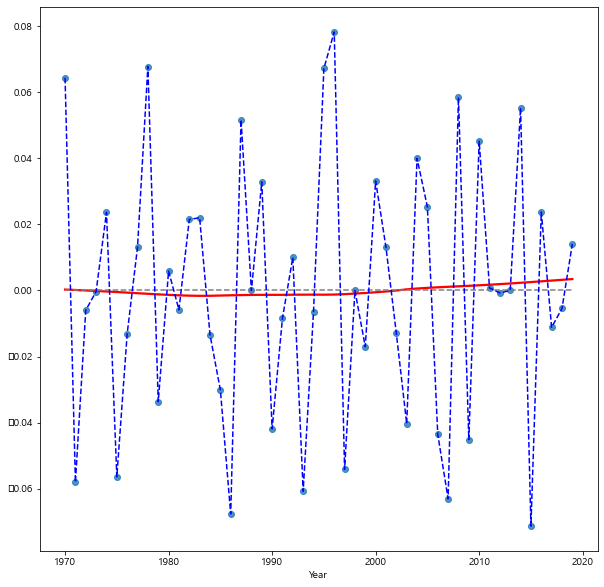

In [1147]:
Y_predict = model.predict(japan)
residual = japan['lnY'] - Y_predict

plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (10, 10)
sns.regplot(residual.index, residual, lowess=True, line_kws={'color': 'red'})
plt.plot([residual.index.min(), residual.index.max()], [0, 0], '--', color='grey')
plt.plot(residual.index, residual, '--', color='blue')


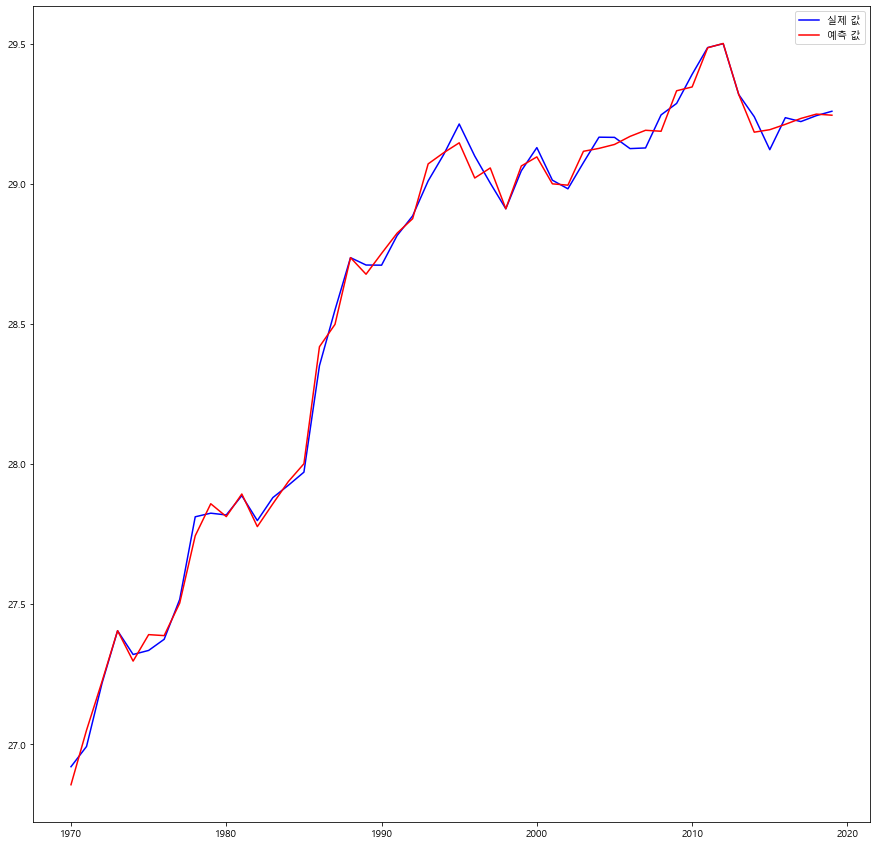

In [1148]:
plt.rc("font", family='Malgun Gothic')
plt.rcParams["figure.figsize"] = (15, 15)
plt.plot(japan.index, japan['lnY'], color='blue', label='실제 값')
plt.plot(Y_predict.index, Y_predict, color='red', label='예측 값')
plt.legend()


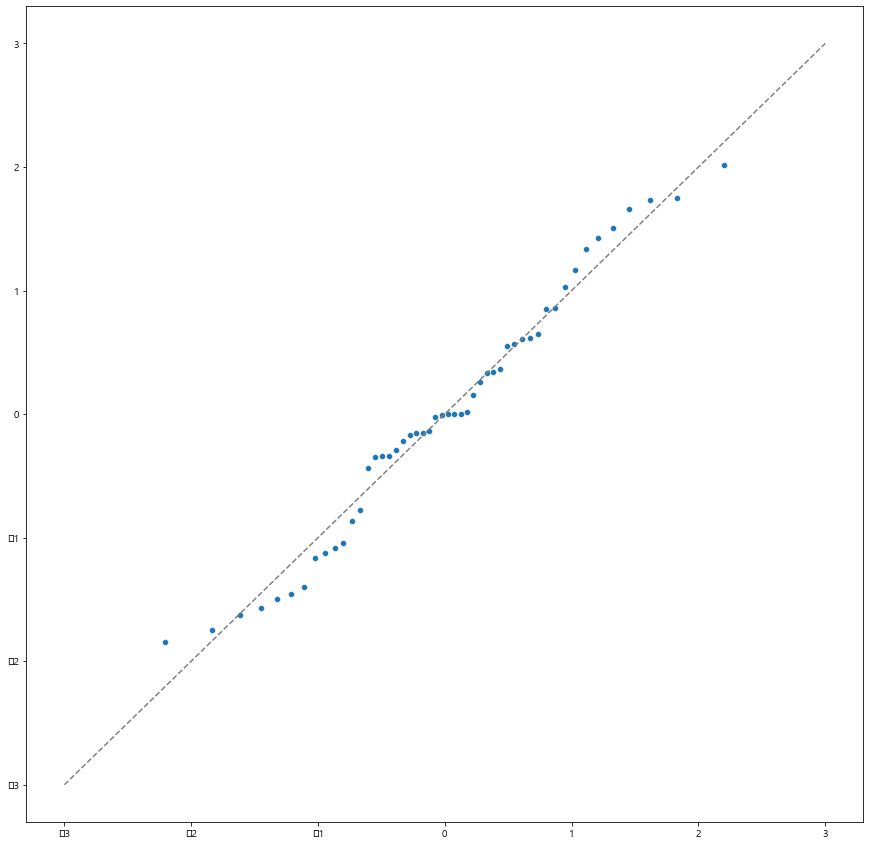

In [1149]:
sr = scipy.stats.zscore(residual)
(x, y), _ = scipy.stats.probplot(sr)
sns.scatterplot(x, y)
plt.plot([-3, 3], [-3, 3], '--', color='grey')

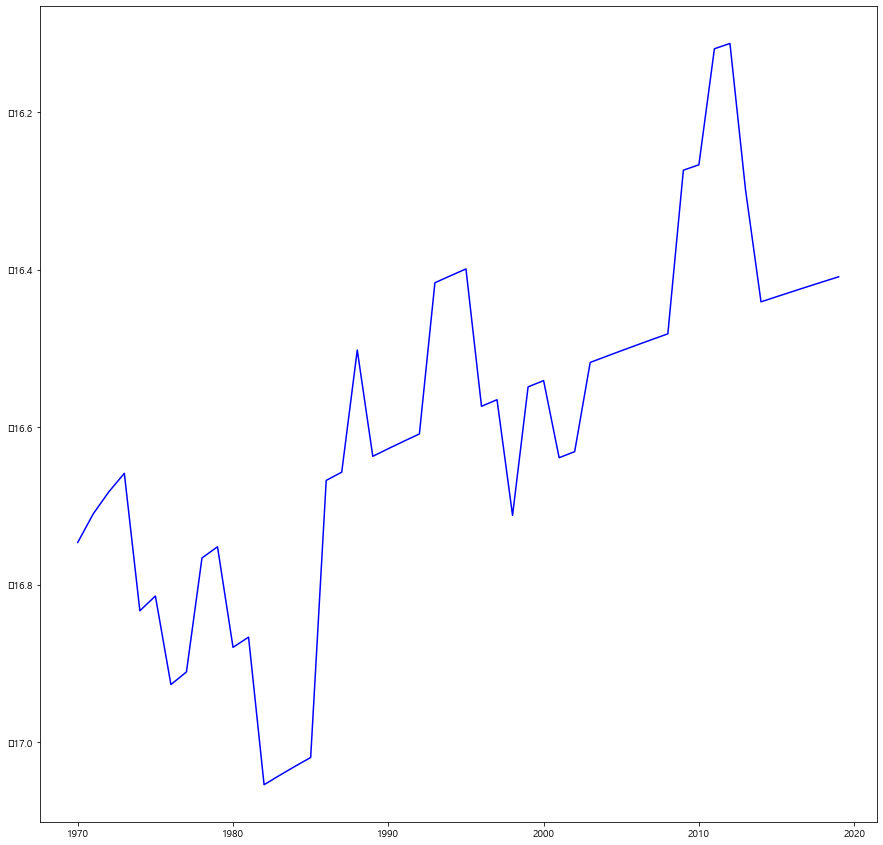

In [1150]:
lnA = Y_predict - japan['lnK']*1.3053 - japan['lnL']*1.2611
plt.plot(lnA.index, lnA, color='blue')


=> 회귀분석 식으로 추정한 lnA 값의 그래프

In [1151]:
Y = japan['lnY'].to_numpy()
Y_avg = np.average(Y)
feture = japan.drop('lnY', axis=1)
X = feture.to_numpy()

N = len(japan)
K = len(feture.columns)

XX = X.transpose().dot(X)
XX_inv = np.linalg.inv(XX)
XY = X.transpose().dot(Y)

beta = XX_inv.dot(XY)
for i, b in enumerate(beta):
    print(feture.columns[i], "의 계수 값 : ", np.around(b,4))



lnK 의 계수 값 :  1.3053
lnL 의 계수 값 :  1.2611
trend 의 계수 값 :  0.0877
dummy_70_to_73 의 계수 값 :  0.1952
dummy_76_to_77 의 계수 값 :  -0.1297
dummy_80_to_81 의 계수 값 :  -0.1412
dummy_82_to_85 의 계수 값 :  -0.3411
dummy_88 의 계수 값 :  0.1448
dummy_93_to_95 의 계수 값 :  0.183
dummy_98 의 계수 값 :  -0.1551
dummy_01_to_02 의 계수 값 :  -0.1057
dummy_09_to_10 의 계수 값 :  0.2008
dummy_11_to_12 의 계수 값 :  0.3414
dummy_13 의 계수 값 :  0.1493
intercept 의 계수 값 :  -17.0294


In [1152]:
Y_hat = X.dot(beta)
Y_hat_avg = np.average(Y_hat)
resid = Y - Y_hat

print("Durbin Watson : ", durbin_watson(resid))


SSR = resid**2
SSE = (Y_hat - Y_hat_avg)**2
SST = (Y - Y_avg)**2
SST

e_std_dev = SSR.sum()/(N-K)
R_square = SSE.sum()/SST.sum()

print("R-sauare : ", R_square)
adj_R_square = 1 - ( (SSR.sum()/(N-K)) / (SST.sum()/N) )
print("adj R-sauare : ", adj_R_square)

beta_var = e_std_dev * XX_inv
beta_var_diag =np.diag(beta_var)
beta_var_inv = np.linalg.inv(beta_var)
beta_var_inv_dig = np.diag(beta_var_inv)

std_dev_beta = np.sqrt(beta_var_diag)
t_value = beta/std_dev_beta
for i, b in enumerate(beta):
    print(feture.columns[i], '의T 통계량 : ', np.around(t_value[i],4))

Durbin Watson :  2.488896974328604
R-sauare :  0.9973880123407208
adj R-sauare :  0.9962685901354198
lnK 의T 통계량 :  11.0366
lnL 의T 통계량 :  4.4799
trend 의T 통계량 :  2.7429
dummy_70_to_73 의T 통계량 :  4.8076
dummy_76_to_77 의T 통계량 :  -3.2767
dummy_80_to_81 의T 통계량 :  -3.8956
dummy_82_to_85 의T 통계량 :  -12.5543
dummy_88 의T 통계량 :  2.9098
dummy_93_to_95 의T 통계량 :  6.0411
dummy_98 의T 통계량 :  -3.1899
dummy_01_to_02 의T 통계량 :  -2.835
dummy_09_to_10 의T 통계량 :  5.319
dummy_11_to_12 의T 통계량 :  9.3545
dummy_13 의T 통계량 :  3.0597
intercept 의T 통계량 :  -4.1474


In [1153]:
R = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
r = np.array([1])

RVR_inv = np.linalg.inv(np.matmul(np.matmul(R, beta_var), R.transpose()))
RVR_inv

Rb = (np.matmul(R, beta)-r).transpose()

np.matmul(RVR_inv, Rb)

chai_sq = np.matmul(Rb.transpose(), np.matmul(RVR_inv, Rb))
chai_sq

print("[JAPAN] Wald Test 카이제곱통계량 : ", chai_sq)

[JAPAN] Wald Test 카이제곱통계량 :  54.8522511074439
